In [143]:
import h5py
import pandas as pd
with pd.HDFStore('MiningProcess_Flotation_Plant_Database_train_split_variables.h5') as store:
    X_cal = store.get('X_cal')
    Y_cal = store.get('Y_cal')


X = X_cal.values
Y = Y_cal.values

X.shape

(936, 20)

In [144]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
import numpy as np

lv_nums = 7
n_pred_obs = 3

windows = [30,40,50,60,70]
R2_mean = np.zeros((len(windows),lv_nums))
Q2_mean = np.zeros((len(windows),lv_nums))
# coefs = np.zeros((len(windows),lv_nums, X.shape[1]))
for ii,window_size in enumerate(windows):
# for ii,window_size in enumerat e([100]):
    
    N_seg = X.shape[0]-window_size-n_pred_obs
    for latent_variables in range(1,lv_nums+1):
    # for latent_variables in [2]:
        model = make_pipeline(StandardScaler(), PLSRegression(n_components=latent_variables))
        R2 = []
        Q2 = []
        for seg in range(N_seg):
            # X_seg_cal = X[current_time-window_size:current_time,:]
            # X_seg_test = X[current_time:current_time+lv_nums,:]
            # Y_seg_cal = Y[current_time-window_size:current_time]
            # Y_seg_test = Y[current_time:current_time+lv_nums]
            X_seg_cal = X[ seg:seg+window_size, : ] 
            X_seg_test = X[ seg+window_size:seg+window_size+n_pred_obs, : ]
            Y_seg_cal = Y[ seg:seg+window_size ]
            Y_seg_test = Y[ seg+window_size:seg+window_size+n_pred_obs ]    
            
            # Center Y
            # Y_seg_cal = Y_seg_cal - Y_seg_cal.mean()
            # Y_seg_test = Y_seg_test - Y_seg_test.mean()

            model.fit(X_seg_cal, Y_seg_cal)

            Y_cal_pred = model.predict(X_seg_cal)
            Y_test_pred = model.predict(X_seg_test)

            outlier_mask =  (Y_test_pred < 0) | (Y_test_pred > 6) | (abs(Y_test_pred - Y_seg_cal[-1])>2.5)

            # coefs[ii,latent_variables-1,:] = model.named_steps['plsregression'].coef_

            # Replace outliers with previous predicted value
            Y_test_pred[outlier_mask] = Y_seg_cal[-1]
            
            # Calculate R2
            TSSRes  = np.sum( ( Y_seg_cal - np.mean(Y_seg_cal) )**2 );
            RSSRes  = np.sum( ( Y_seg_cal - Y_cal_pred )**2 );
            R2.append( 1 - RSSRes / TSSRes )

            # Calculate Q2
            pRESS = np.sum( ( Y_seg_test - Y_test_pred )**2 )
            Q2_val = 1 - pRESS / TSSRes
            Q2.append(Q2_val)

            
           
            # R2.append(r2_score(Y_seg_cal,Y_cal_pred))
            # Q2.append(r2_score(Y_seg_test,Y_test_pred))

            # current_time += 1
        R2_mean[ii,latent_variables-1] = np.mean(R2)
        Q2_mean[ii,latent_variables-1] = np.mean(Q2)








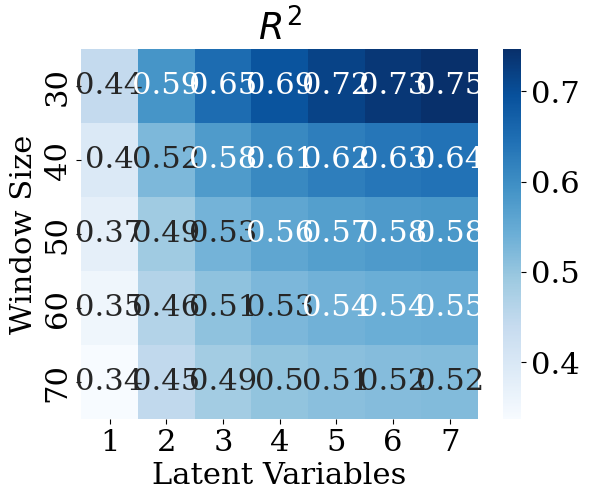

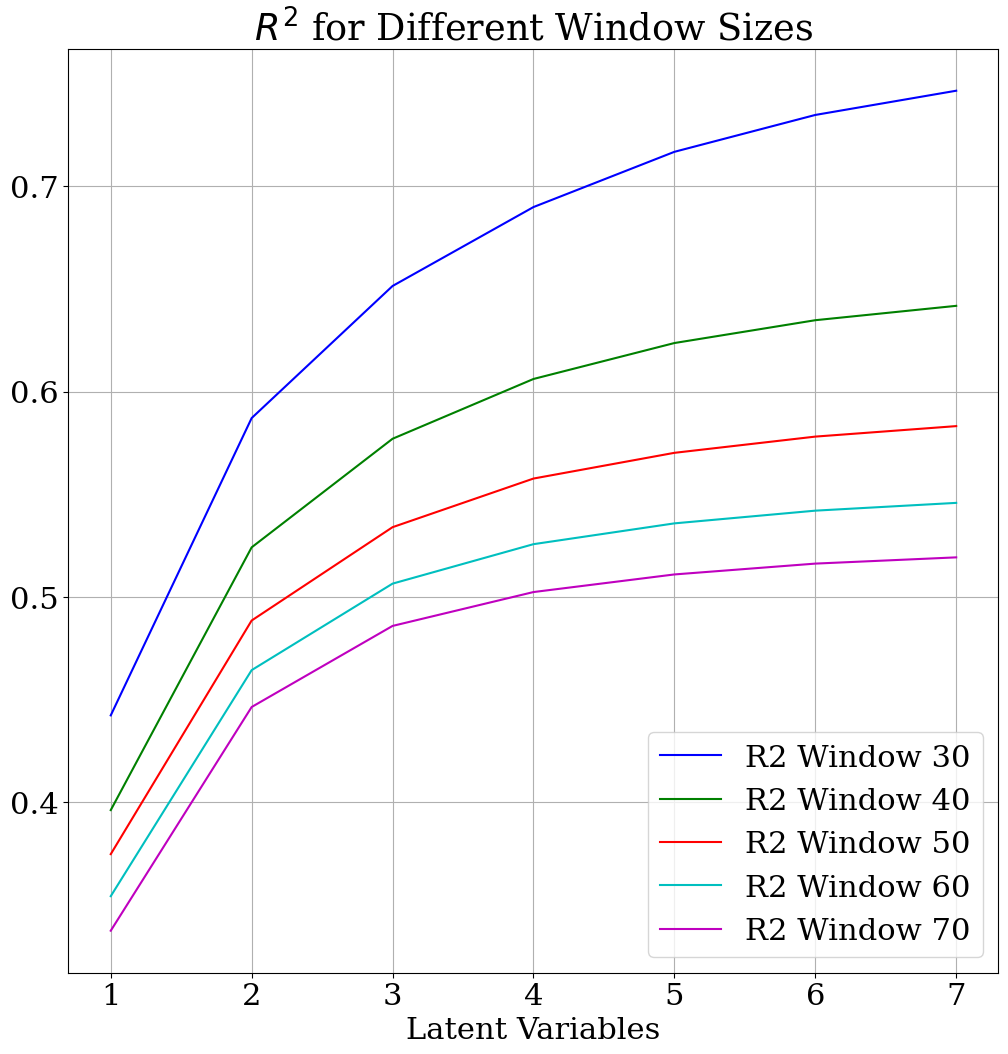

Text(0.5, 1.0, '$Q^2$')

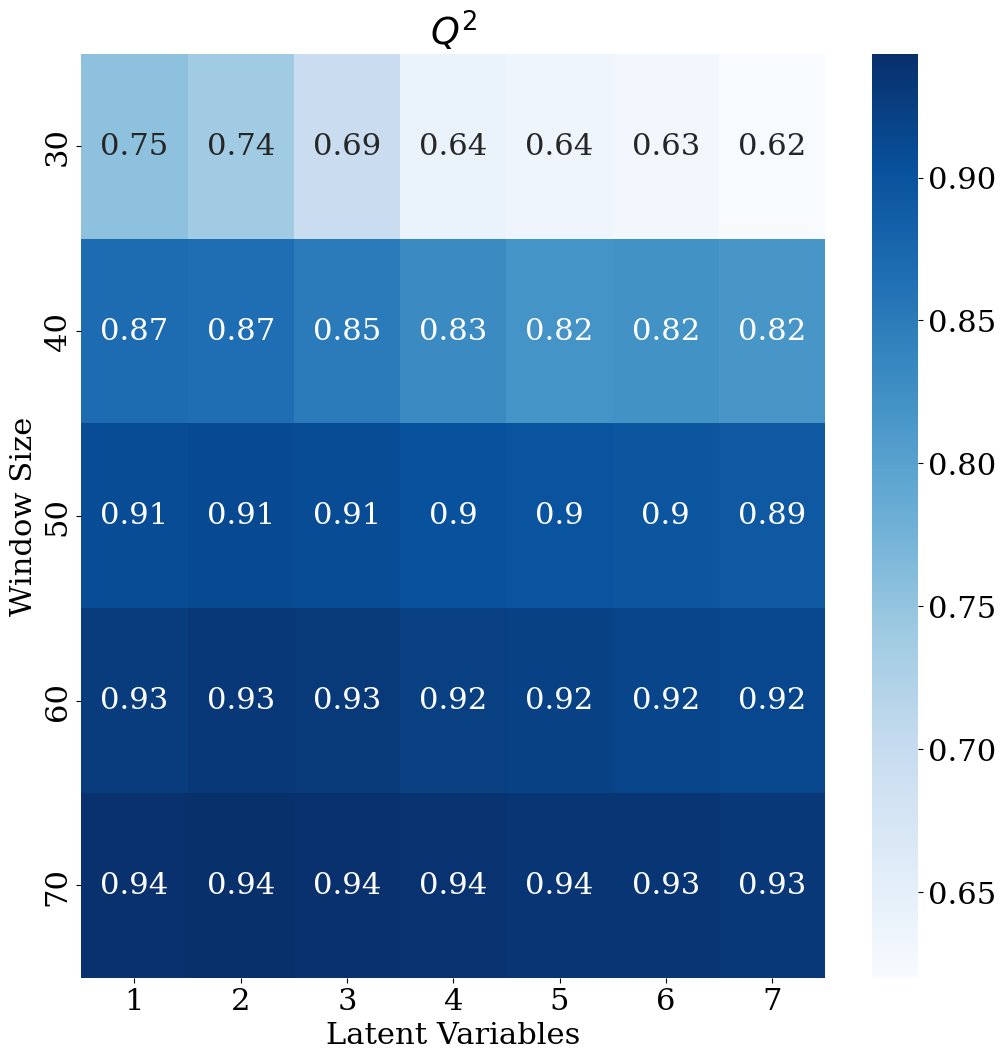

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
    "font.family": "serif ",
    "font.size":22
})
windows = [30,40,50,60,70]
heatmap_R2 = plt.figure()
sns.heatmap(R2_mean, annot=True, xticklabels=range(1,lv_nums+1), yticklabels=windows,cmap='Blues')
plt.ylabel('Window Size')
plt.xlabel('Latent Variables')
plt.title(r'$R^2$')

plt.figure(figsize=(12,12))
colors = ['b', 'g', 'r', 'c', 'm','b', 'g', 'r', 'c', 'm']
for i in range(R2_mean.shape[0]):
    plt.plot(range(1, lv_nums + 1), R2_mean[i, :], label=f'R2 Window {windows[i]}', color=colors[i])
    # plt.plot(range(1, lv_nums + 1), Q2_mean[i, :], label=f'Q2 Window {windows[i]}', linestyle='--', color=colors[i])
plt.xlabel('Latent Variables')
# plt.ylabel(r'$R^2$')
plt.title(r'$R^2$ for Different Window Sizes')
plt.legend()
plt.grid(True)
plt.show()

heatmap_Q2 = plt.figure(figsize=(12,12))
#/np.array(windows).reshape(-1,1)
sns.heatmap(Q2_mean, annot=True, xticklabels=range(1,lv_nums+1), yticklabels=windows,cmap='Blues')
plt.ylabel('Window Size')
plt.xlabel('Latent Variables')
plt.title(r'$Q^2$')
# plt.plot(R2_mean.T)
# plt.plot(Q2_mean[0:,:2].T)
# plt.ylim(-10,1.1)

# Variable selection

In [146]:
latent_variables = 5
window_size = 40

N_seg = X.shape[0]-window_size


model = make_pipeline(StandardScaler(), PLSRegression(n_components=latent_variables))
# R2 = []
# Q2 = []
coefs = np.zeros((N_seg,X.shape[1]))
for seg in range(N_seg):

    X_seg_cal = X[ seg:seg+window_size, : ] 
    X_seg_test = X[ seg+window_size:seg+window_size+n_pred_obs, : ]
    Y_seg_cal = Y[ seg:seg+window_size ]
    Y_seg_test = Y[ seg+window_size:seg+window_size+n_pred_obs ]    


    model.fit(X_seg_cal, Y_seg_cal)

    coefs[seg,:] = model.named_steps['plsregression'].coef_



<Axes: >

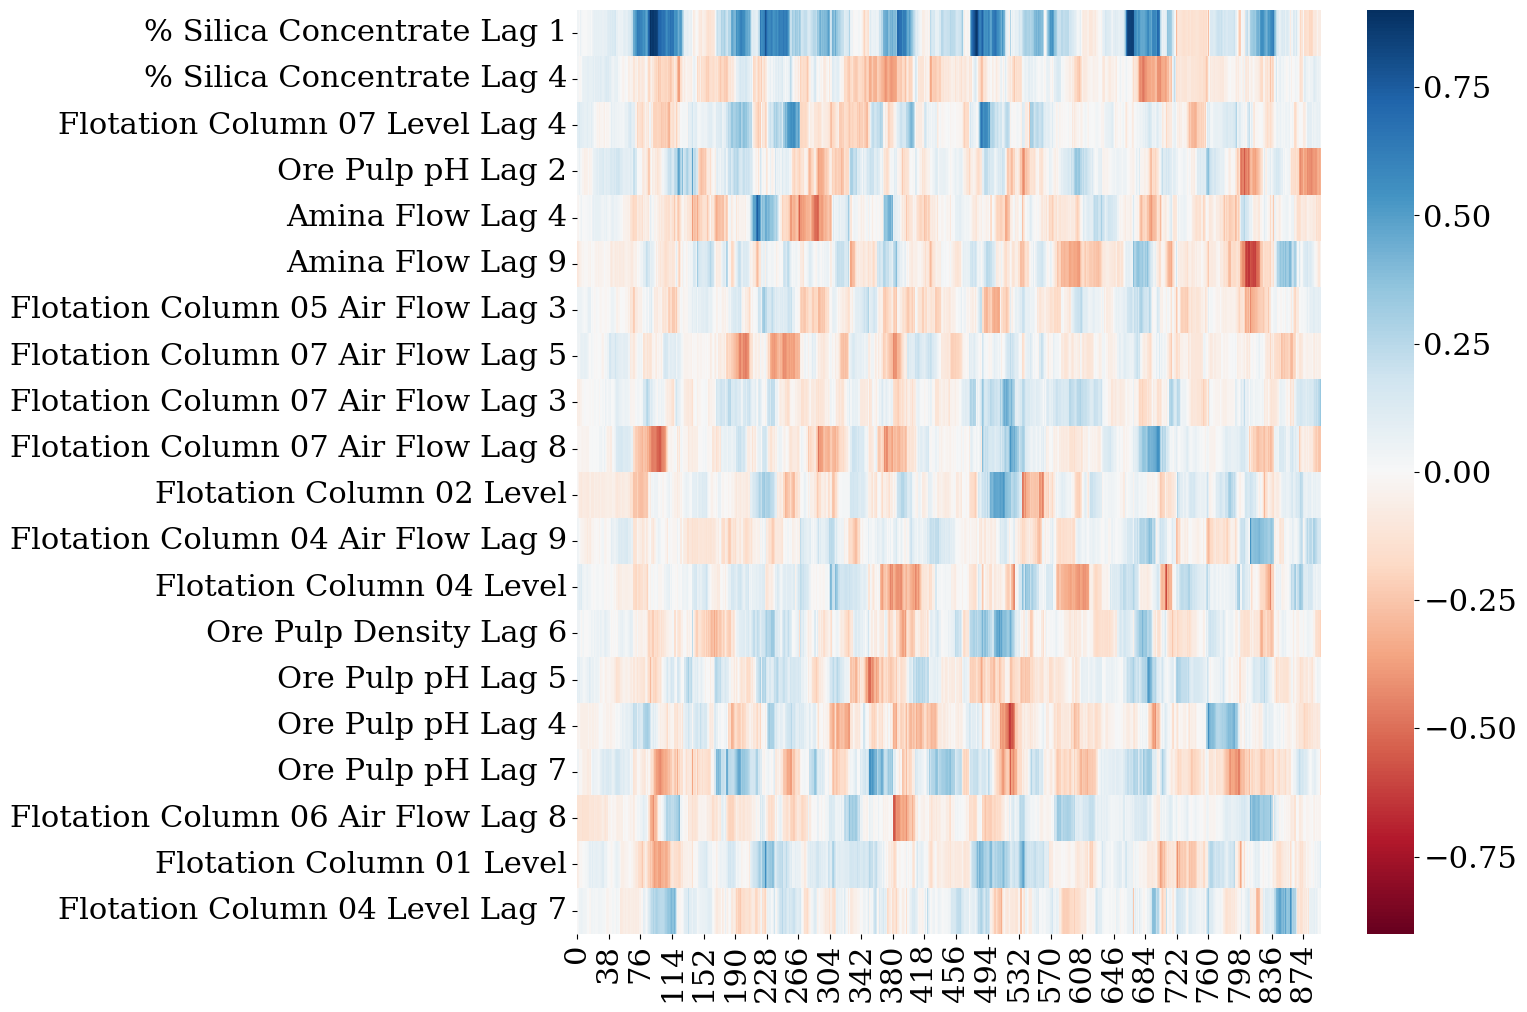

In [147]:
plt.figure(figsize=(12,12))

max_val = np.max(abs(coefs))
sns.heatmap(coefs.T,yticklabels=X_cal.columns,cmap='RdBu',vmax=max_val,vmin=-max_val)

#   